In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn as sk


print("tf.__version__ = ", tf.__version__)
print("pd.__version__ = ", pd.__version__)
print("sklearn.__version__ = ", sk.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
bc = pd.read_csv("E:\Faculty\semster 7\CS 415\CancerDet_CS415_Project\AI\Dataset\crc_dataset.csv")
bc['Pre-existing Conditions'] = bc['Pre-existing Conditions'].replace('None', 'None_val')

bc.head()
bc.info()
# lc_shape = bc.shape  # (rows, columns)
# print(lc_shape)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Momen\AppData\Local\Temp\ipykernel_9512\45438776.py:1: SyntaxWarning: invalid escape sequence '\F'
  bc = pd.read_csv("E:\Faculty\semster 7\CS 415\CancerDet_CS415_Project\AI\Dataset\crc_dataset.csv")


C:\Users\Momen\AppData\Local\Temp\ipykernel_9512\45438776.py:1: SyntaxWarning: invalid escape sequence '\F'
  bc = pd.read_csv("E:\Faculty\semster 7\CS 415\CancerDet_CS415_Project\AI\Dataset\crc_dataset.csv")


NameError: name 'pd' is not defined

In [ ]:
# CHECK 2: DUPLICATES
# ==========================================
print("\n Checking for Duplicates...")

# Copying the data
df = bc.copy()


# We exclude 'index' and 'Patient Id' because unique IDs hide real duplicates
cols_to_check = df.columns.drop(['Participant_ID'])

# 'keep=False' marks ALL duplicates as True so we can see them
duplicate_rows = df[df.duplicated(subset=df.columns, keep=False)]
num_duplicates = df.duplicated(subset=df.columns).sum()

print(f"Total duplicate rows found: {num_duplicates}")

if num_duplicates > 0:
    print("\n Here is a preview of the duplicates (Top 6 rows):")
    # We sort them so you can see the identical pairs side-by-side
    print(duplicate_rows.sort_values(by=['Age', 'Gender']).head(6))

    # ==========================================
    #     ACTION: REMOVE DUPLICATES
    # ==========================================
#     print(f"\ Removing duplicates...")
#     # Keep the first occurrence, drop the rest
#     df = df.drop_duplicates(subset=cols_to_check, keep='first')
#     print(f" Duplicates removed. New dataset shape: {df.shape}")
#
# else:
#     print(" No duplicates found. The data is unique.")


 Checking for Duplicates...
Total duplicate rows found: 0


In [ ]:
# Drop 'id' (it's not a feature)
df = df.drop(columns=['Participant_ID'])
if not ('Participant_ID' in df.columns):
    print("Dropped 'Participant_ID'")

Dropped 'Participant_ID'


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 2. ENCODING (Text -> Numbers)
# ==========================================
# We use LabelEncoder for Gender, Lifestyle, Ethnicity, etc.
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
df = df.fillna('None') # Just in case

# We will save the encoders just in case you need them for the app later
encoders = {}
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
    encoders[col] = le # Store it if needed

In [ ]:
#     CHECK 1: MISSING VALUES
# ==========================================
print("\n Checking for Missing Data...")
missing_values = df.isna().sum()

# Filter to show only columns that actually have missing values
missing_only = missing_values[missing_values > 0]

if missing_only.empty:
    print("Great! No missing values found in any column.")
else:
    print("Found missing values in these columns:")
    print(missing_only)


 Checking for Missing Data...
Great! No missing values found in any column.


In [ ]:
# 3. SPLIT & SCALE
# ==========================================
X = df.drop(columns=['CRC_Risk'])
y = df['CRC_Risk']

# Stratify is CRITICAL here because we only have 155 sick people
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"✅ Data Processed. Training on {X_train.shape[0]} rows.")

✅ Data Processed. Training on 800 rows.


In [ ]:
model = keras.Sequential([
    # STEP 1: Input Shape
    # Use X_train.shape[1] to get the exact number of columns.
    keras.Input(shape=(X_train.shape[1],)),

    # STEP 2: Hidden Layers
    # Common choice: Powers of 2 (32, 64, 128).
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(8, activation='relu'),

    # STEP 3: Output Layer
    # Binary Classification uses '1' neuron with 'sigmoid' activation.
    # Sigmoid forces the result to be between 0 and 1 (Probability).
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# STEP 4: Compile & ADD CLASS WEIGHTS
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight
import numpy as np

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Calculate weights automatically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_dict = dict(enumerate(weights))

Epoch 1/50
40/40 - 3s - 84ms/step - accuracy: 0.7953 - auc: 0.4888 - loss: 0.8441 - precision: 0.1224 - recall: 0.0638 - val_accuracy: 0.7875 - val_auc: 0.5086 - val_loss: 0.5567 - val_precision: 0.3000 - val_recall: 0.1000
Epoch 2/50
40/40 - 0s - 7ms/step - accuracy: 0.7672 - auc: 0.5270 - loss: 0.7600 - precision: 0.1333 - recall: 0.1064 - val_accuracy: 0.7500 - val_auc: 0.5347 - val_loss: 0.5765 - val_precision: 0.2500 - val_recall: 0.1667
Epoch 3/50
40/40 - 0s - 6ms/step - accuracy: 0.7766 - auc: 0.5767 - loss: 0.7020 - precision: 0.2366 - recall: 0.2340 - val_accuracy: 0.7500 - val_auc: 0.5577 - val_loss: 0.5936 - val_precision: 0.2917 - val_recall: 0.2333
Epoch 4/50
40/40 - 0s - 10ms/step - accuracy: 0.7312 - auc: 0.5742 - loss: 0.7000 - precision: 0.1750 - recall: 0.2234 - val_accuracy: 0.7000 - val_auc: 0.5837 - val_loss: 0.6078 - val_precision: 0.2500 - val_recall: 0.3000
Epoch 5/50
40/40 - 0s - 6ms/step - accuracy: 0.7125 - auc: 0.6023 - loss: 0.6763 - precision: 0.1875 - rec

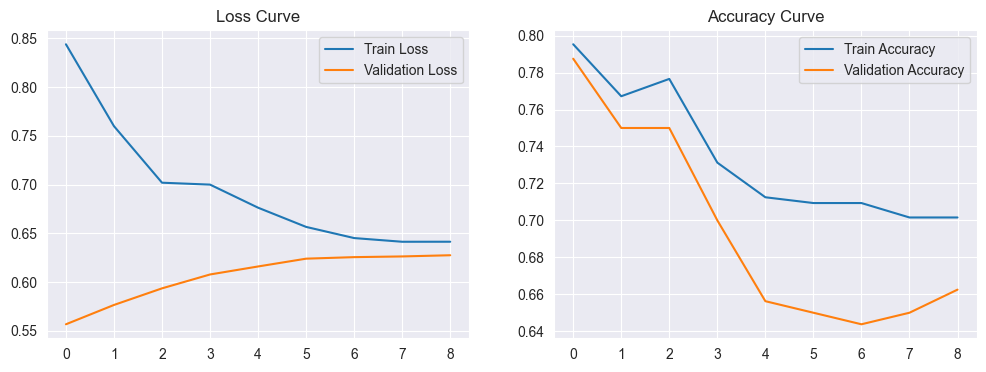

In [ ]:
# STEP 5: Train

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    # CHANGE 1: Increase Batch Size for 50k rows
    batch_size=16,

    # CHANGE 2: Since we have 50k rows, using a real validation split
    # is better than reusing the Test set.
    validation_split=0.2,

    callbacks=[early_stop],

    class_weight=weight_dict, # <--- Added this!

    verbose=2
)

# ==========================================
#    PLOT THE LEARNING CURVE
# ==========================================
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') # Fixed label
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Fixed label
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score,confusion_matrix

# 1. Get raw probabilities
y_pred_prob = model.predict(X_test)

thresholds = [0.3,0.4,0.5, 0.6, 0.7, 0.8]

print(f"{'Threshold':<10} | {'Precision':<10} | {'Recall':<10} | {'False Alarms'} |   {'F1-Score':<10}")
print("-" * 55)


for t in thresholds:
    preds = (y_pred_prob > t).astype(int)

    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # False Alarms are Top-Right in Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    false_alarms = cm[0][1]


    print(f"{t:<10} | {prec:.4f}     | {rec:.4f}     | {false_alarms}          | {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Threshold  | Precision  | Recall     | False Alarms |   F1-Score  
-------------------------------------------------------
0.3        | 0.1524     | 0.5161     | 89          | 0.2353
0.4        | 0.1636     | 0.2903     | 46          | 0.2093
0.5        | 0.2500     | 0.0968     | 9          | 0.1395
0.6        | 0.0000     | 0.0000     | 0          | 0.0000
0.7        | 0.0000     | 0.0000     | 0          | 0.0000
0.8        | 0.0000     | 0.0000     | 0          | 0.0000



📊 Model Performance:
   -> loss: 0.5337
   -> compile_metrics: 0.8150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

First 10 Predictions (Threshold 0.3):
Pred: 1 | Actual: 1 | Prob: 0.3708
Pred: 0 | Actual: 0 | Prob: 0.1967
Pred: 1 | Actual: 0 | Prob: 0.4519
Pred: 0 | Actual: 0 | Prob: 0.2572
Pred: 1 | Actual: 0 | Prob: 0.5225
Pred: 1 | Actual: 0 | Prob: 0.4935
Pred: 1 | Actual: 0 | Prob: 0.4378
Pred: 1 | Actual: 0 | Prob: 0.3204
Pred: 1 | Actual: 0 | Prob: 0.4732
Pred: 0 | Actual: 0 | Prob: 0.2359

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.47      0.61       169
           1       0.15      0.52      0.24        31

    accuracy                           0.48       200
   macro avg       0.50      0.49      0.42       200
weighted avg       0.74      0.48      0.55       200



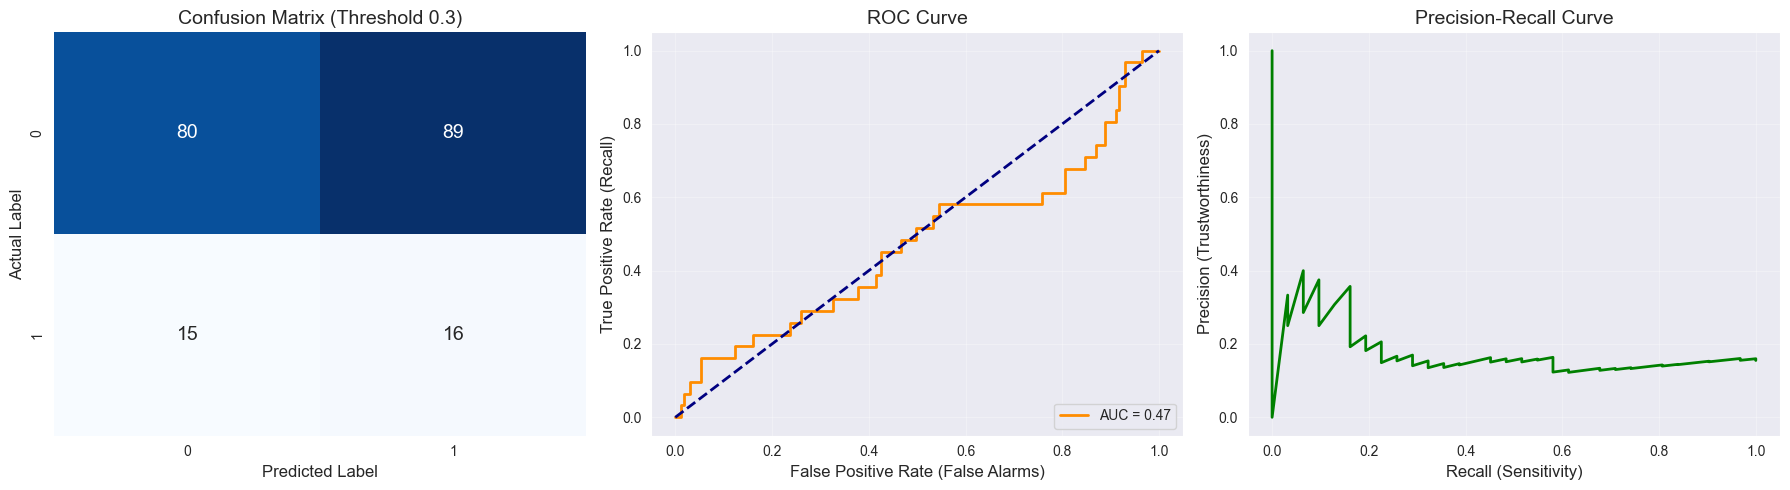

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# ==========================================
# 1. EVALUATE & PREDICT
# ==========================================
# ==========================================
# 1. EVALUATE (Crash-Proof Version)
# ==========================================
results = model.evaluate(X_test, y_test, verbose=0)

print("\n📊 Model Performance:")
# If results is just a single number (Loss only), make it a list
if not isinstance(results, list):
    results = [results]

# Print whatever metrics are available
for name, value in zip(model.metrics_names, results):
    print(f"   -> {name}: {value:.4f}")

# Get raw probabilities
predictions = model.predict(X_test)

# APPLY YOUR CHOSEN THRESHOLD (0.3)
THRESHOLD = 0.3
predicted_classes = (predictions > THRESHOLD).astype("int32")
actual_classes = np.array(y_test)

# ==========================================
# 2. TEXT REPORT
# ==========================================
print("\nFirst 10 Predictions (Threshold 0.3):")
for i in range(10):
    print(f"Pred: {predicted_classes[i][0]} | Actual: {actual_classes[i]} | Prob: {predictions[i][0]:.4f}")

print("\nClassification Report:")
print(classification_report(actual_classes, predicted_classes))

# ==========================================
# 3. PLOTS
# ==========================================
plt.figure(figsize=(18, 5))

# --- Plot A: Confusion Matrix ---
plt.subplot(1, 3, 1)
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.title(f'Confusion Matrix (Threshold {THRESHOLD})', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

# --- Plot B: ROC Curve (Good for overall performance) ---
fpr, tpr, _ = roc_curve(actual_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlabel('False Positive Rate (False Alarms)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# --- Plot C: Precision-Recall Curve (Best for Imbalanced Data) ---
precision, recall, _ = precision_recall_curve(actual_classes, predictions)

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Trustworthiness)', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# 7. SAVE EVERYTHING
# ==========================================
model.save('colon_risk_model.keras')
joblib.dump(scaler, 'colon_scaler.pkl')
print("✅ Model & Scaler Saved!")

✅ Model & Scaler Saved!


In [ ]:
import joblib

# 7. SAVE EVERYTHING
# ==========================================
model.save('colon_risk_model.keras')
joblib.dump(scaler, 'colon_scaler.pkl')

['colon_scaler.pkl']

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import json

# 1. Load your original dataset
df = pd.read_csv('crc_dataset.csv')

# 2. Identify the text columns we need to map
# (These are the ones you used LabelEncoder on)
cat_cols = [
    'Gender', 
    'Lifestyle', 
    'Ethnicity', 
    'Family_History_CRC', 
    'Pre-existing Conditions'
]

mapping_dict = {}

# 3. Generate the map
print("Generating Mappings...")
for col in cat_cols:
    # We fit a FRESH encoder for each column to get the correct list
    le = LabelEncoder()
    le.fit(df[col].astype(str))
    
    # Create the dictionary: {"Male": 1, "Female": 0}
    # zip combines the text names with their number codes
    col_map = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Convert numpy integers to standard Python ints (for JSON compatibility)
    col_map = {k: int(v) for k, v in col_map.items()}
    
    mapping_dict[col] = col_map
    print(f"✅ {col}: {col_map}")

# 4. Save to JSON
filename = 'colon_mappings.json'
with open(filename, 'w') as f:
    json.dump(mapping_dict, f, indent=4)

print(f"\n🎉 Success! '{filename}' has been created.")
print("👉 Move this file into your 'SmartClinic_Backend' folder.")

ModuleNotFoundError: No module named 'pandas'